In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, unpack_csr_matrix, get_sparse_hessian

import matplotlib.pyplot as plt
%matplotlib inline

#import numpy as np

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')
vb_results = pickle.load(pkl_file)


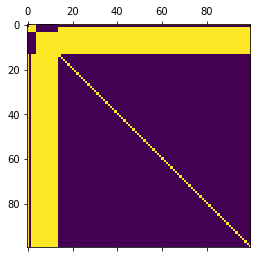

In [3]:
import scipy as sp
from scipy.sparse import csr_matrix

elbo_hess = unpack_csr_matrix(vb_results['elbo_hess_packed'])
plt.matshow(elbo_hess.todense()[0:100, 0:100] != 0)

In [4]:
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)

K = x_mat.shape[1]
NG = np.max(y_g_vec) + 1

# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

dict_keys(['mu_prior_info', 'NG', 'N', 'mu_prior_mean', 'y_group', 'tau_prior_alpha', 'tau_prior_beta', 'beta_prior_info', 'K', 'x', 'y', 'beta_prior_mean'])


In [5]:
import time

free_par_vec = vb_results['glmm_par_free']
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_results['num_gh_points'])
objective = Objective(model.glmm_par, model.get_kl)

id_vec = np.zeros_like(free_par_vec)
hvp_time = time.time()
objective.fun_free_hvp(free_par_vec, id_vec)
hvp_time = time.time() - hvp_time

print(hvp_time)
print(hvp_time * glmm_par.free_size())
print(vb_results['hess_time'])

opt_x = vb_results['glmm_par_free']
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = vb_results['moment_jac']


0.027511119842529297
5.8873796463012695
6.998855829238892


In [6]:
group_range = np.random.randint(0, NG, 50)
print(group_range)

print(np.max(range(10)))

[48 77 49 68 48 44 18 70 58 80 65 55 14  3 88 23 19 55 58 10 53 61  3 16 66
 22 57 41 36 44 14 76 57 92 80 57 44 47 73 33 98 65 42 75 45 82 57 28 95 71]
9


In [7]:
# Get the Hessians at the number of draws used for optimization
sparse_model = logit_glmm.SparseModelObjective(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, vb_results['num_gh_points'])
sparse_model.glmm_par.set_free(opt_x)

hess_time = time.time()
print('KL Hessian...\n')

print('Calculating global hessian:')
sparse_global_hess = get_sparse_hessian(
    set_parameters_fun = sparse_model.set_global_parameters,
    get_group_hessian = sparse_model.get_global_vector_hessian,
    group_range = range(1),
    full_hess_dim = sparse_model.glmm_par.vector_size(),
    print_every = 1)

group_range = [ [g] for g in np.random.randint(0, NG, 10) ]

print('Calculating local hessian:')
sparse_group_hess = get_sparse_hessian(
    set_parameters_fun = sparse_model.set_group_parameters,
    get_group_hessian = sparse_model.get_group_vector_hessian,
    group_range = group_range,
    full_hess_dim = sparse_model.glmm_par.vector_size(),
    print_every = 10)

sparse_vector_hess = sparse_group_hess + sparse_global_hess
sample_elbo_hess = sparse_model.get_free_hessian(sparse_vector_hess)




KL Hessian...

Calculating global hessian:
Group 1 of 0
Done.
Calculating local hessian:
Group 10 of 9
Done.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


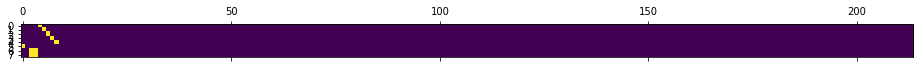

In [8]:
moment_indices = logit_glmm.MomentWrapper(glmm_par)
moment_indices.moment_par.set_vector(np.arange(moment_indices.moment_par.vector_size()))

global_moment_indices = np.hstack(
    [ moment_indices.moment_par['e_beta'].get(),
      moment_indices.moment_par['e_mu'].get(),
      moment_indices.moment_par['e_tau'].get(),
      moment_indices.moment_par['e_log_tau'].get() ])

global_moment_jac = moment_jac[global_moment_indices, :]
plt.matshow(global_moment_jac != 0)


glmm_indices = logit_glmm.get_glmm_parameters(K=K, NG=NG)
glmm_indices.set_vector(np.arange(glmm_indices.vector_size()))

global_indices =  np.hstack(
    [ glmm_indices['beta'].get_vector(),
      glmm_indices['mu'].get_vector(),
      glmm_indices['tau'].get_vector() ])
local_indices = glmm_indices['u'].get_vector()



In [9]:
sparse_vector_hess = unpack_csr_matrix(vb_results['sparse_vector_hess_packed'])

h = sparse_vector_hess
h_gg = h[np.ix_(global_indices, global_indices)]
h_gl = h[np.ix_(global_indices, local_indices)]
h_ll = h[np.ix_(local_indices, local_indices)]

# TODO: think about how to do this.

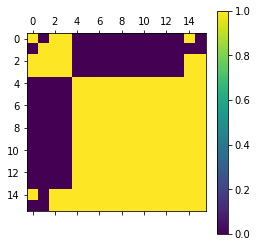

In [11]:
group = [0]
set_parameters_fun = sparse_model.set_group_parameters
get_group_hessian = sparse_model.get_group_vector_hessian

group_vector, full_indices = set_parameters_fun(group)
row_hess_val = np.squeeze(get_group_hessian(group_vector, group))
plt.matshow(row_hess_val != 0); plt.colorbar()


In [14]:
# Time using conjugate gradient to get a single row of the moment sensitivity.
import scipy as sp
from scipy.sparse.linalg import LinearOperator

elbo_inv_moment_jac = vb_results['elbo_inv_moment_jac']

class OptimumHVP(object):
    def __init__(self, glmm_par, opt_x, moment_jac):
        self.verbose = False
        self.print_every = 10
        self.reset_iter()
        self.opt_x = opt_x
        self.moment_jac = moment_jac
        self.lo = LinearOperator(
            (glmm_par.free_size(), glmm_par.free_size()), self.hvp)
        
    def reset_iter(self):
        self.iter = 0
    
    def hvp(self, vec):
        self.iter += 1
        if self.verbose and self.iter % self.print_every == 0:
            print('Iter ', self.iter)
        return objective.fun_free_hvp(self.opt_x, vec)
    
    def get_moment_sensitivity_row(self, moment_row):
        self.reset_iter()
        moment_jac_vec = moment_jac[moment_row, :].flatten()
        cg_res, info = sp.sparse.linalg.cg(self.lo, moment_jac_vec)
        return cg_res, info

moment_row = 0
optimum_hvp = OptimumHVP(glmm_par, opt_x, moment_jac)
optimum_hvp.verbose = True
optimum_hvp.print_every = 20
cg_row_time = time.time()
cg_res, info = optimum_hvp.get_moment_sensitivity_row(0)
cg_row_time = time.time() - cg_row_time

print('CG time: ', cg_row_time)
print('Number of iterations: ', optimum_hvp.iter)

print(np.max(np.abs(cg_res - elbo_inv_moment_jac[:, moment_row].flatten())))

Iter  20
CG time:  0.27057838439941406
Number of iterations:  23
5.73995687717e-06


In [ ]:
moment_indices = logit_glmm.MomentWrapper(glmm_par)
moment_indices.moment_par.set_vector(np.arange(moment_indices.moment_par.vector_size()))

global_indices = np.hstack(
    [ moment_indices.moment_par['e_beta'].get(),
      moment_indices.moment_par['e_mu'].get(),
      moment_indices.moment_par['e_tau'].get(),
      moment_indices.moment_par['e_log_tau'].get() ])

optimum_hvp.verbose = False
cg_time = time.time()
global_elbo_inv_moment_jac = np.full((len(global_indices), glmm_par.free_size()), float('nan'))
for moment_row in global_indices:
    print('Moment row ', moment_row, ' of ', len(global_indices))
    cg_row_time = time.time()
    cg_res, info = optimum_hvp.get_moment_sensitivity_row(moment_row)
    cg_row_time = time.time() - cg_row_time
    print('Row time: ', cg_row_time)
    global_elbo_inv_moment_jac[moment_row, :] = cg_res

cg_time = time.time() - cg_time

print('Done.  Time: ', cg_time)

In [ ]:
print(moment_jac.shape)

# Check the accuracy.
foo = elbo_inv_moment_jac[:, global_indices].T
print(np.max(np.abs(global_elbo_inv_moment_jac - foo)))

# Get the components of column vector vec orthogonal to and along the rows of matrix x.
def projection_components(x, vec):
    xtx = np.matmul(x, x.T)
    vec_along = np.matmul(x.T, np.linalg.solve(xtx, np.matmul(x, vec)))
    return vec - vec_along, vec_along
    
# Except for tau, most of the multiplications we need to do are orthogonal, so
# I don't think you can use the results from one iteration to speed up the next.
for i in range(1, 10):
    vec_orth, vec_along = projection_components(moment_jac[0:i, :], moment_jac[i, :])    
    print('i: ', i, ' Orthogonal: ', np.linalg.norm(vec_orth), ' Along: ', np.linalg.norm(vec_along))

# plt.plot(global_elbo_inv_moment_jac.flatten(), foo.flatten(), 'k.')
# plt.plot(foo.flatten(), foo.flatten(), 'r+')

In [ ]:
# Perhaps you can use a Schur complement and this trick to get the covariance of the
# global parameters or, indeed, any select local parameters.

hess_ind = 0

id_vec = np.zeros_like(opt_x)
id_vec[hess_ind] = 1
hess_col = objective.fun_free_hvp(opt_x, id_vec)
print(np.max(np.abs(hess_col + elbo_hess[hess_ind, :])))